In [51]:
import os
import cv2
import time
import numpy as np
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt

In [62]:
data_path   = './data'
img_source = [
    'icons/arrow.png',
    'icons/bow.png',
    'icons/shield.png',
    'icons/touch.png',
    'show.png'
]
IQ          = 5   # Image quality:画质等级，数字越大越差0, 1, 2, 3, 5
SEP         = 30  # Septal:图标间距的像素值
R           = 60  # 触碰圆半径
H           = 480 # 图片的高
W           = 640 # 图片的宽
LC          = (int(640*1/4), int(480/3))  # 左侧触碰圆圆心
RC          = (int(640*3/4), int(480/3))  # 右侧触碰圆圆心
ICO         = []  # 存储图标
ico_index   = []  # 图标索引
show_data   = np.zeros((130,640,3))  # 数据展示区域

mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands          = mp.solutions.hands
for name in img_source:
    im = Image.open(os.path.join(data_path, name))
    # png转jpg
    im = im.convert('RGB')
    # RGB转BGR格式，并按画质等级降低画质
    if 'show' in name or 'touch' in name:
        im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    else:
        im = cv2.cvtColor(np.array(im)[::IQ,::IQ], cv2.COLOR_RGB2BGR)
    ICO.append(im)
    ico_index.append(np.where(im != 0))

In [25]:
def get_landmarks(multi_hand_landmarks):
    '''
    将mediapipe的识别结果转换为列表形式方便操作
    multi_hand_landmarks:多手坐标results.multi_hand_landmarks
    '''
    land_marks = []
    for hand_landmarks in multi_hand_landmarks:
        tmp = str(hand_landmarks).replace('\n', '').replace('{', '').replace('landmark  ', '').replace('}', ' ').replace('  ', ' ').replace(':', '')[1:-1].split(' ')
        land_marks.append([(float(tmp[i+1]), float(tmp[i+3])) for i in range(0, len(tmp), 6)])
    return land_marks

def get_label(multi_handedness):
    '''
    得到mediapipe对左右手的识别结果
    multi_handedness:识别标签results.multi_handedness
    '''
    hands_info = {}
    index      = 0
    for hand_info in multi_handedness:
        hand_info = str(hand_info).replace('\n', '').replace('  ',' ').replace('"', '').replace('}', '')
        hand_info = hand_info.split(' ')
        hands_info[hand_info[7]] = (index, float(hand_info[5]))
        index += 1
    return hands_info

def chartlet(img ,icon, quality=1, icon_index=None):
    '''
    向原图贴加图标，原理是从原图和图标中的像素值加权后相加得到叠加图像
    img:        array待叠加的图像
    icon:       array待叠加的图标
    quality:    0.0-1.0图标的透明度
    icons_index:图标中的有效部分
    '''
    if not icon_index:
        icon_index = np.where(icon != 0)
    img  = np.array(img,  np.uint8)
    icon = np.array(icon, np.uint8)
    for i in range(len(icon_index[0])):
        img[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]] = img[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]]*(1 - quality) + icon[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]]*quality
    return img

def show_skill(frame, arrow, bow, shield):
    '''
    在图片上显示技能数量
    frame:       array将要显示的图片
    arrow:       (person, ai)箭的数量
    bow:         (person, ai)弓箭的数量
    shield:      (person, ai)盾的数量
    '''
    pe_num = [arrow[0], bow[0], shield[0]]
    ai_num = [arrow[1], bow[1], shield[1]]
    for index in range(3):
        h, w = ICO[index].shape[:-1]
        # 绘制人类选手技能
        frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)] = chartlet(frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)], ICO[index], icon_index=ico_index[index])
        frame = cv2.putText(frame, str(pe_num[index]), (SEP*(index+1)+w*index + int(w/3), SEP*2+h), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # 绘制AI选手技能
        frame[SEP:h+SEP, W-(SEP*(index+1)+w*(index+1)):W-(SEP*(index+1)+w*index)] = chartlet(frame[SEP:h+SEP, W-(SEP*(index+1)+w*(index+1)):W-(SEP*(index+1)+w*index)], ICO[index], icon_index=ico_index[index])
        frame = cv2.putText(frame, str(ai_num[index]), (W-(SEP*(index+1)+w*index + int(w*2/3)), SEP*2+h), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return frame

def touch_place(frame, hand_points):
    cv2.circle(frame, LC, R, (0,0,0), thickness=2)
    cv2.circle(frame, RC, R, (0,0,0), thickness=2)
    # todo 触碰判断
    return frame

In [104]:
def draw_ico(frame):
    '''
    绘制技能图标、触碰区等

    frame: 待绘制图像
    '''
    for index in range(3):
        h, w = ICO[index].shape[:-1]
        # 绘制人类选手技能
        frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)] = chartlet(frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)], ICO[index], icon_index=ico_index[index])
        # 绘制AI选手技能
        frame[SEP:h+SEP, W-(SEP*(index+1)+w*(index+1)):W-(SEP*(index+1)+w*index)] = chartlet(frame[SEP:h+SEP, W-(SEP*(index+1)+w*(index+1)):W-(SEP*(index+1)+w*index)], ICO[index], icon_index=ico_index[index])
    # 绘制触碰区
    frame[ico_index[3][:2]]=np.array([0,0,255])
    return frame

def draw_data(frame, skill_data, figure_data):
    '''
    绘制技能数目等数据

    skill_data: [arrow, bow, shield]ai、人类的技能数据，依次是箭、弓、盾
    figure_data : [[aileft, airight, pleft, pright],[aileft, airight, pleft, pright]]手势数据，依次是实际的ai、人类的左右手数字，检测的ai、人类的左右手数字
    '''
    pe_num = skill_data[3:]
    ai_num = skill_data[:3]
    for index in range(3):
        h, w = ICO[index].shape[:-1]
        # 绘制人类选手技能
        frame = cv2.putText(frame, str(pe_num[index]), (SEP*(index+1)+w*index + int(w/3), SEP*2+h), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # 绘制AI选手技能
        frame = cv2.putText(frame, str(ai_num[index]), (W-(SEP*(index+1)+w*index + int(w*2/3)), SEP*2+h), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    # 绘制手势数据
    return frame

# 计算point1与point2之间的距离
d = lambda point1, point2:((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5

def get_number(hand_points):
    '''
    判断当前手所示数字

    hand_points: 手的坐标
    '''
    pose = {
        '000000':0, # 五指全收
        '010000':1, # 食指不收
        '011000':2, # 食中不收
        '011100':3, # 大小指收
        '001110':3, # 大小指收
        '011100':3, # 大小指收
        '011110':4, # 大拇指收
        '111110':5, # 全部不收
        '100010':6, # 大小不收
        '111000':7, # 小无指收
        '110000':8, # 大食不收
        '000001':9, # 食指蜷缩
        '010001':9, # 食指蜷缩
    }
    number = []
    try:
        hand0, hand1 = hand_points
    except:
        hand0 = hand_points[0]
    pose_key = '%d%d%d%d%d%d'%(
        # 判断五指是否伸直
        d(hand0[3], hand0[17]) <= d(hand0[4], hand0[17]),  # 拇指
        d(hand0[0], hand0[ 5]) <= d(hand0[0], hand0[ 7]),  # 食指
        d(hand0[0], hand0[10]) <= d(hand0[0], hand0[11]),  # 中指
        d(hand0[0], hand0[14]) <= d(hand0[0], hand0[15]),  # 无名
        d(hand0[0], hand0[18]) <= d(hand0[0], hand0[19]),  # 小指
        # 特殊数字9
        d(hand0[6], hand0[ 8]) <= d(hand0[6], hand0[ 5])/2,  # 9 食指
        #d(hand0[4], hand0[12]) >= d(hand0[4], hand0[ 8]),  # 9 三指

    )
    print(f"\r{pose_key}", end='')
    try:
        number.append(pose[pose_key])
    except:
        number.append(None)
    if len(hand_points) == 2:
        pose_key = '%d%d%d%d%d%d'%(
            # 判断五指是否伸直
            d(hand1[3], hand1[17]) <= d(hand1[4], hand1[17]),  # 拇指
            d(hand1[0], hand1[ 5]) <= d(hand1[0], hand1[ 7]),  # 食指
            d(hand1[0], hand1[10]) <= d(hand1[0], hand1[11]),  # 中指
            d(hand1[0], hand1[14]) <= d(hand1[0], hand1[15]),  # 无名
            d(hand1[0], hand1[18]) <= d(hand1[0], hand1[19]),  # 小指
            # 特殊数字7和9
            d(hand1[6], hand1[ 8]) <= d(hand1[6], hand1[ 5])/2,  # 7 食指
            #d(hand1[4], hand1[12]) >= d(hand1[4], hand1[ 8]),  # 9 三指
        )
        try:
            number.append(pose[pose_key])
        except:
            number.append(None)
    return number

In [105]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    max_num_hands=2,
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue
        # 取消图像标记可提升程序性能
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 将图片翻转
        image = cv2.flip(image, 1)
        # 进行预测
        results = hands.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks != None:
            # 绘制手部关键点图像
            # for hand_landmarks in results.multi_hand_landmarks:
            #     mp_drawing.draw_landmarks(
            #         image,
            #         hand_landmarks,
            #         mp_hands.HAND_CONNECTIONS,
            #         mp_drawing_styles.get_default_hand_landmarks_style(),
            #         mp_drawing_styles.get_default_hand_connections_style())
            hand_points = get_landmarks(results.multi_hand_landmarks)
            hands_info  = get_label(results.multi_handedness)
            for points in hand_points:
                mid_center = int(points[9][0]*640), int(points[9][1]*480)
                image = cv2.circle(image, mid_center, 3, (0,0,0), thickness=2)
            if len(hand_points[0]) == 21:
                hands_num = get_number(hand_points)
            else:
                hands_num = [None, None]
            for hand_label in hands_info.keys():
                # 若只出现一只手，则不使用索引
                hand_index = 0
                if len(hand_points) > 1:
                    # 若只出现多只手，则使用索引
                    hand_index = hands_info[hand_label][0]
                tmp_point = (
                    int(hand_points[hand_index][0][0]*image.shape[1]),
                    int(hand_points[hand_index][0][1]*image.shape[0])
                )
                # 绘制左右手的标签和检测数字
                image = cv2.putText(image, hand_label, tmp_point, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                image = cv2.putText(image, str(hands_num[hand_index]), (tmp_point[0], tmp_point[1]+50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # 绘制触碰区并判断触碰情况
        #image = touch_place(image,hand_points)
        # 绘制技能信息
        image = draw_ico(image)
        image = draw_data(image, skill_data=[0,0,0,0,0,0], figure_data=[[0,0,0,0],[0,0,0,0]])
        # 拼接数据显示区
        #image = np.concatenate((ICO[-1], image),axis=0)
        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

011110

In [31]:
np.mean(np.array(hand_points[0])[:, 0]), np.mean(np.array(hand_points[0])[:, 1])

(0.3129247575998306, 0.6345796556699843)

In [102]:
image[ico_index[3][:2]]=[0,0,255]

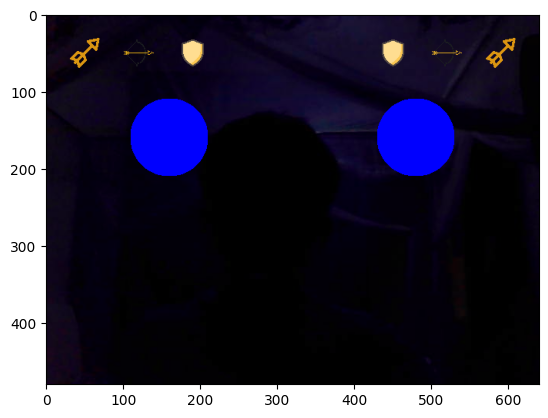

In [103]:
plt.imshow(image)

In [67]:
np.where(ICO[3] == 0)[0]

array([  0,   0,   0, ..., 479, 479, 479], dtype=int64)

In [59]:
print(ICO[3] == 0)

[[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 ...

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  ...
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]]
